# Set up 

In [1]:
import tellurium as te
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import aesara.tensor as at
import aesara
floatX = aesara.config.floatX
import pymc as pm
import numpy as np

import cobra
import os

from scipy import stats
import scipy as sp

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# import sys
# sys.path.insert(0, 'C:/Users/user/Documents/research/BMCA-pipeline')
os.chdir('../..')
from src import BMCA, util
import emll
os.chdir('notebooks/all_data/')

# Perturbing enzymes

In [3]:
Teusink_ant ='../../data/interim/Antimony/BIOMD0000000064_e.ant' 
data_file = '../../data/interim/generated_data/ogTeusink/BIOMD0000000064_e_extANDenzyme1.5perts.csv'
df = pd.read_csv(data_file)

# need to fix this so only rows with concentrations less than 0 are dropped 
data = df.drop(df[df.lt(0).any(axis=1)].index)

r = te.loada(Teusink_ant)
r.conservedMoietyAnalysis = True
r.steadyState()

5.935978122618177e-12

In [4]:
BIOMD64_15 = BMCA.BMCA(Teusink_ant, '../../data/interim/generated_data/ogTeusink/BIOMD0000000064_e_extANDenzyme1.5perts.csv')
BIOMD64_15_1000 = BMCA.BMCA(Teusink_ant, '../../data/interim/generated_data/ogTeusink/BIOMD0000000064_e_extANDenzyme1.5perts-1000.csv')

Model does not contain SBML fbc package information.


../../data/interim/Antimony/BIOMD0000000064_e_cobra.ant
Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-23


Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPGI>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPGI>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLYCO>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLYCO>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vTreha>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vTreha>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPFK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPFK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vALD>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vALD>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGAPDH>'
Missing upper flux bound set to '1

../../data/interim/Antimony/BIOMD0000000064_e_cobra.ant


In [5]:
BMCA_obj = BIOMD64_15
with pm.Model() as pymc_model:
    
    # Initialize elasticities
    Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BMCA_obj.Ex.to_numpy(), name='Ex'))
    Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BMCA_obj.Ey.to_numpy(), name='Ey'))
    e_obs = pm.Normal('e_obs', mu=1, sigma=1, observed=BMCA_obj.en.T)
    pm.Deterministic('en', e_obs)
    chi_obs = pm.Normal('chi_obs', mu=0, sigma=10, observed=BMCA_obj.xn.T)
    pm.Deterministic('chin', chi_obs)
    y_obs = pm.Normal('y_obs', mu=0, sigma=10, observed=BMCA_obj.yn.T)
    pm.Deterministic('yn', y_obs)
    likelihood = pm.Deterministic('vn', e_obs * (np.ones(BMCA_obj.en.T.shape) + pm.math.dot(Ex_t,chi_obs) + pm.math.dot(Ey_t,y_obs)))
    v_hat_obs = pm.Normal('v_hat_obs', mu=likelihood, sigma=0.1, observed=BMCA_obj.vn.squeeze().T)
    pm.Deterministic('v_hat', v_hat_obs)

    trace = pm.sample(1000, tune=100000, random_seed=1, cores=4)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: Ru

Sampling 4 chains for 100_000 tune and 1_000 draw iterations (400_000 + 4_000 draws total) took 341865 seconds.


In [6]:
Ex = (trace['posterior']['Ex']).to_numpy()
Ey = (trace['posterior']['Ey']).to_numpy()

In [7]:
def reshape_elasticity(E):
    tmp = []
    for i in E: 
        tmp.append(i)
    return np.concatenate(tmp)

Ex = reshape_elasticity(Ex)
Ey = reshape_elasticity(Ey)

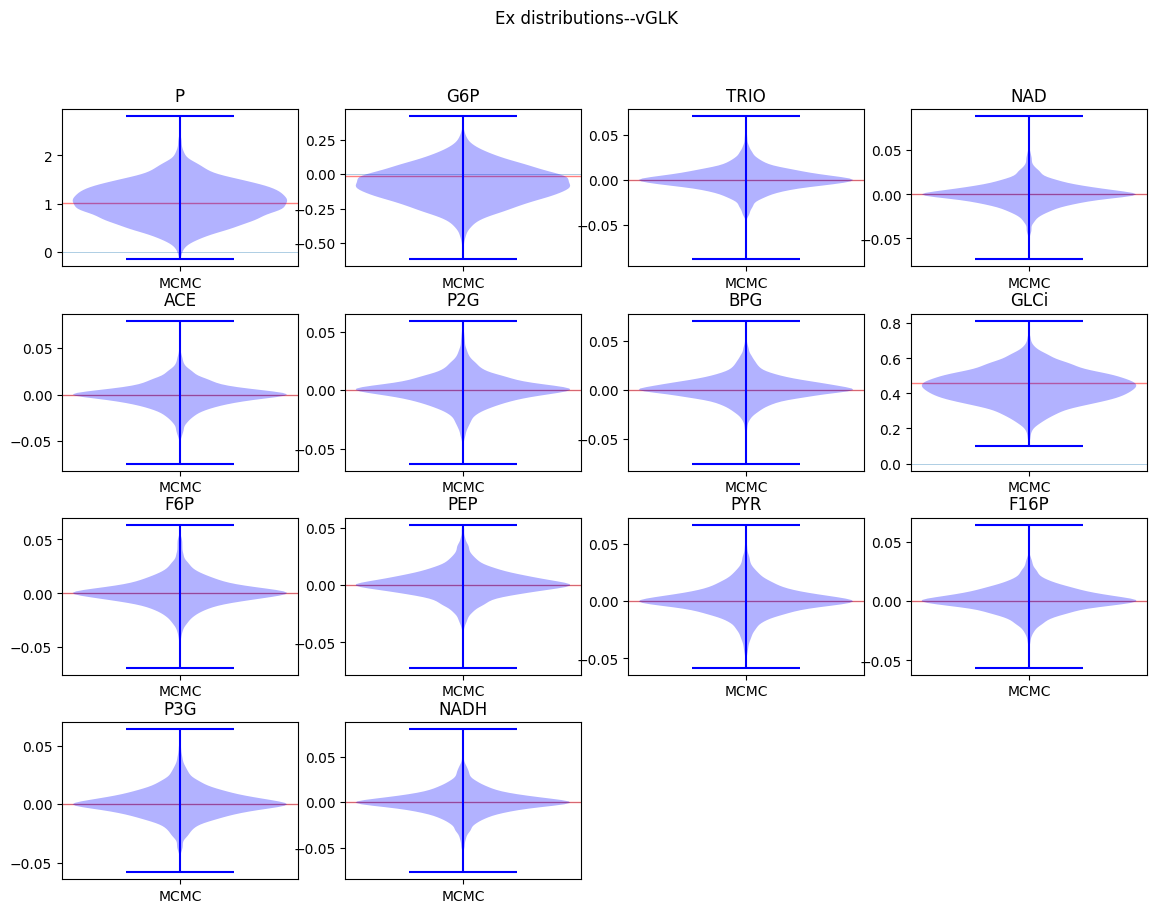

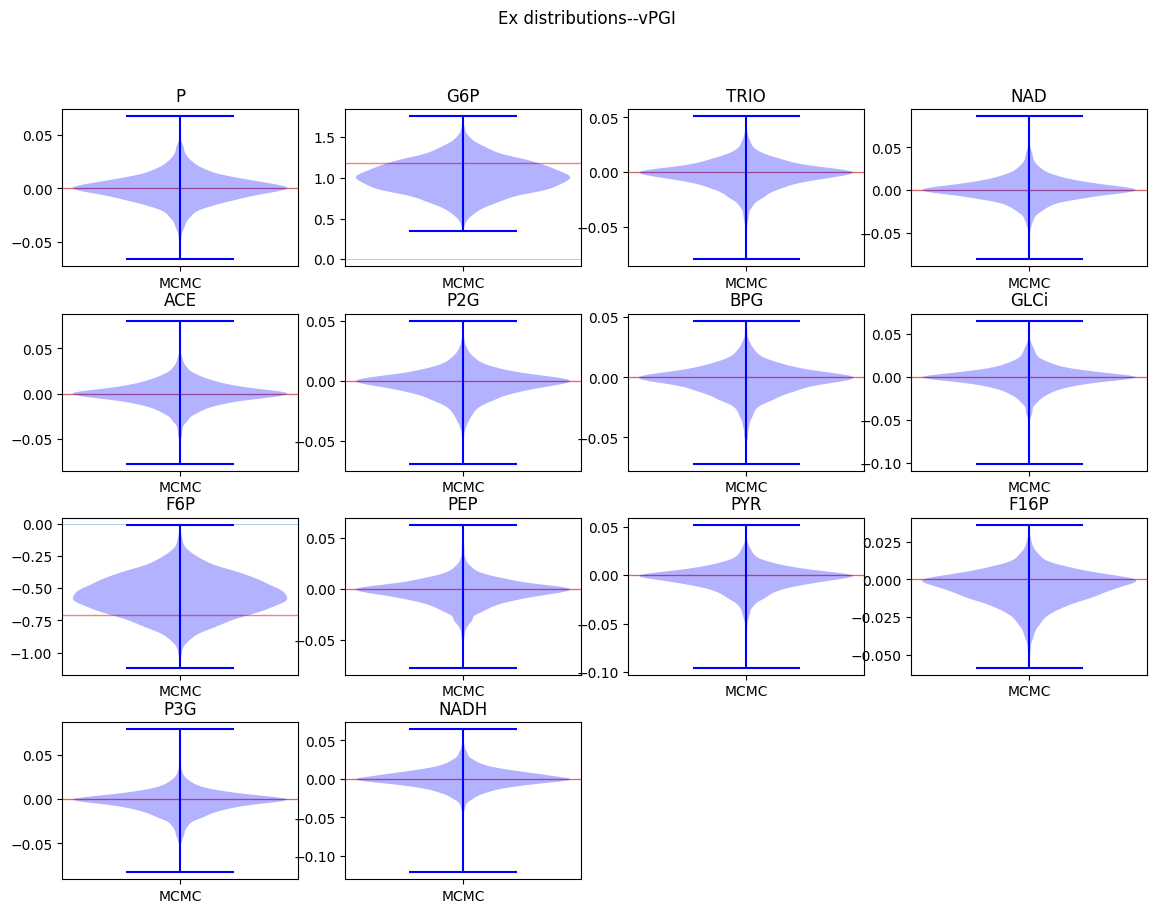

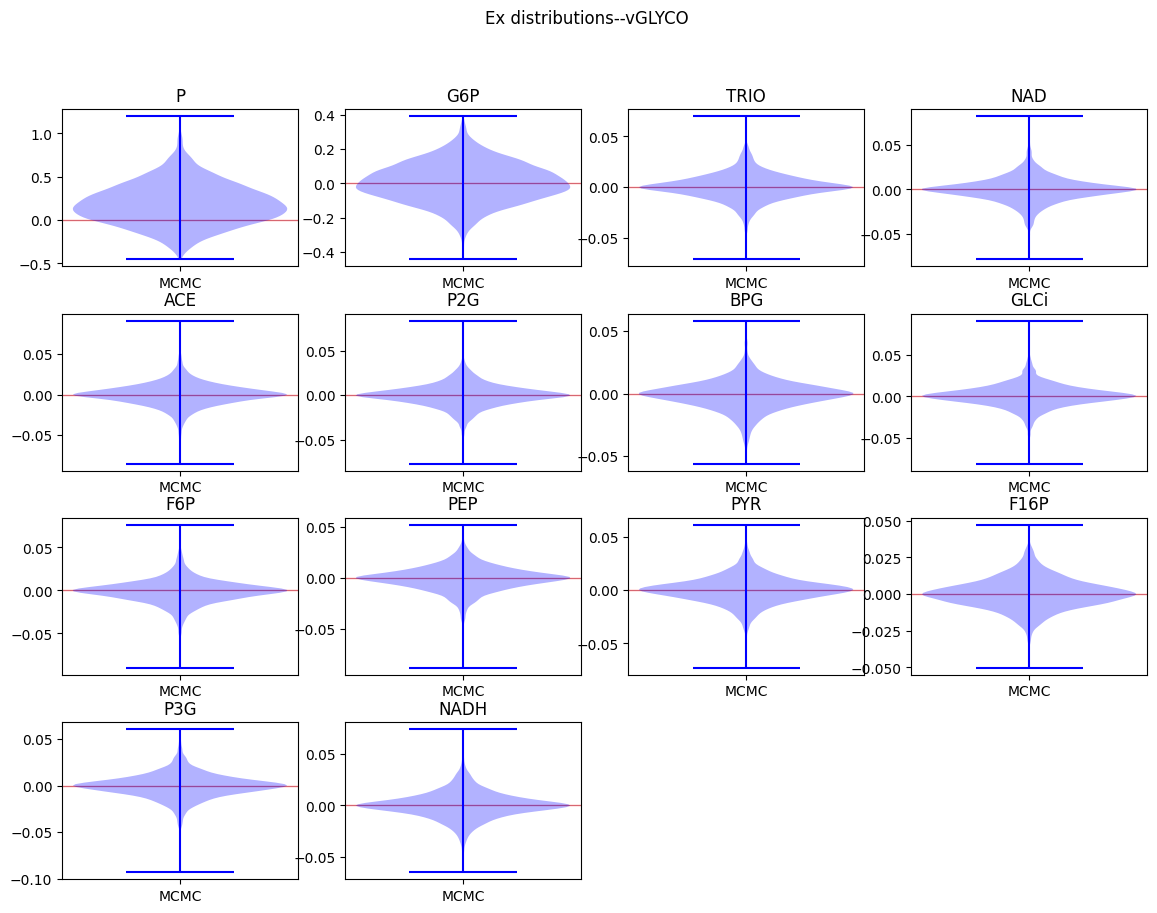

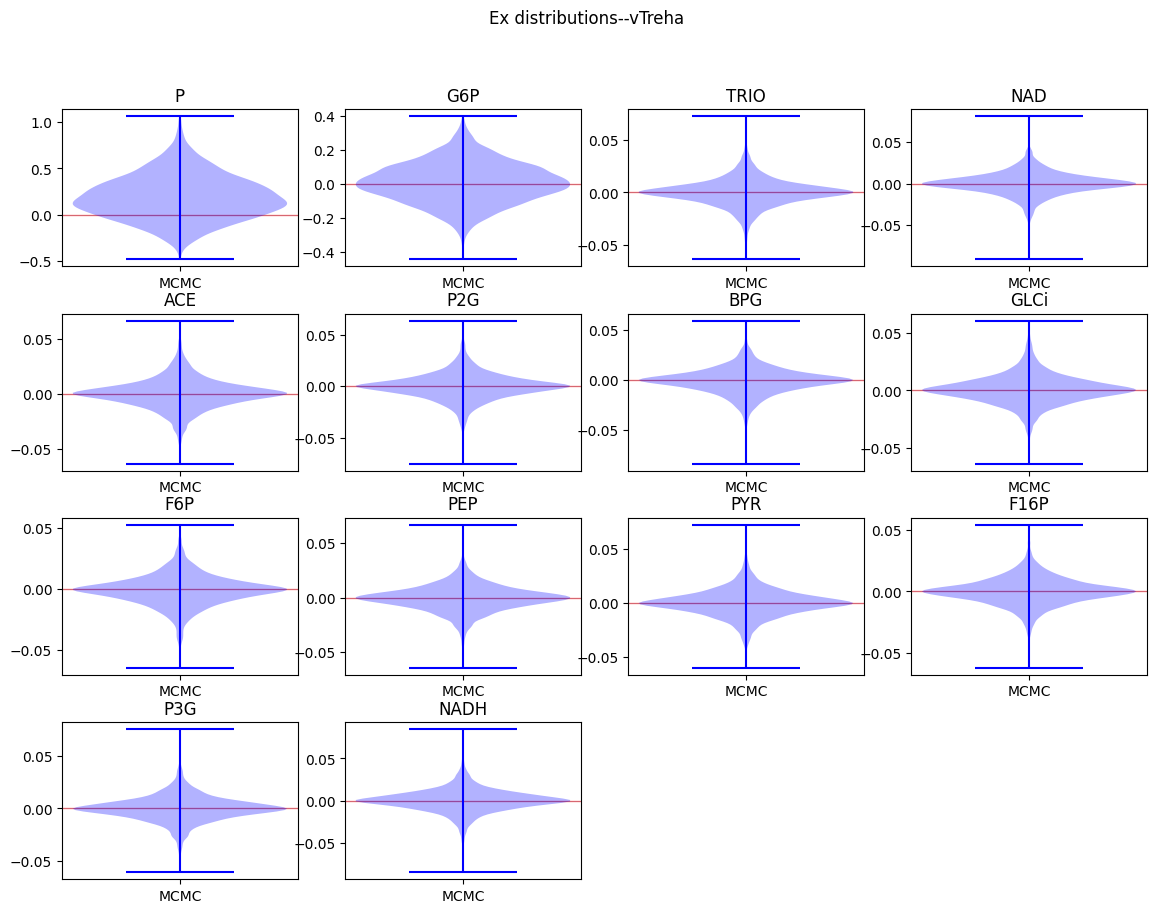

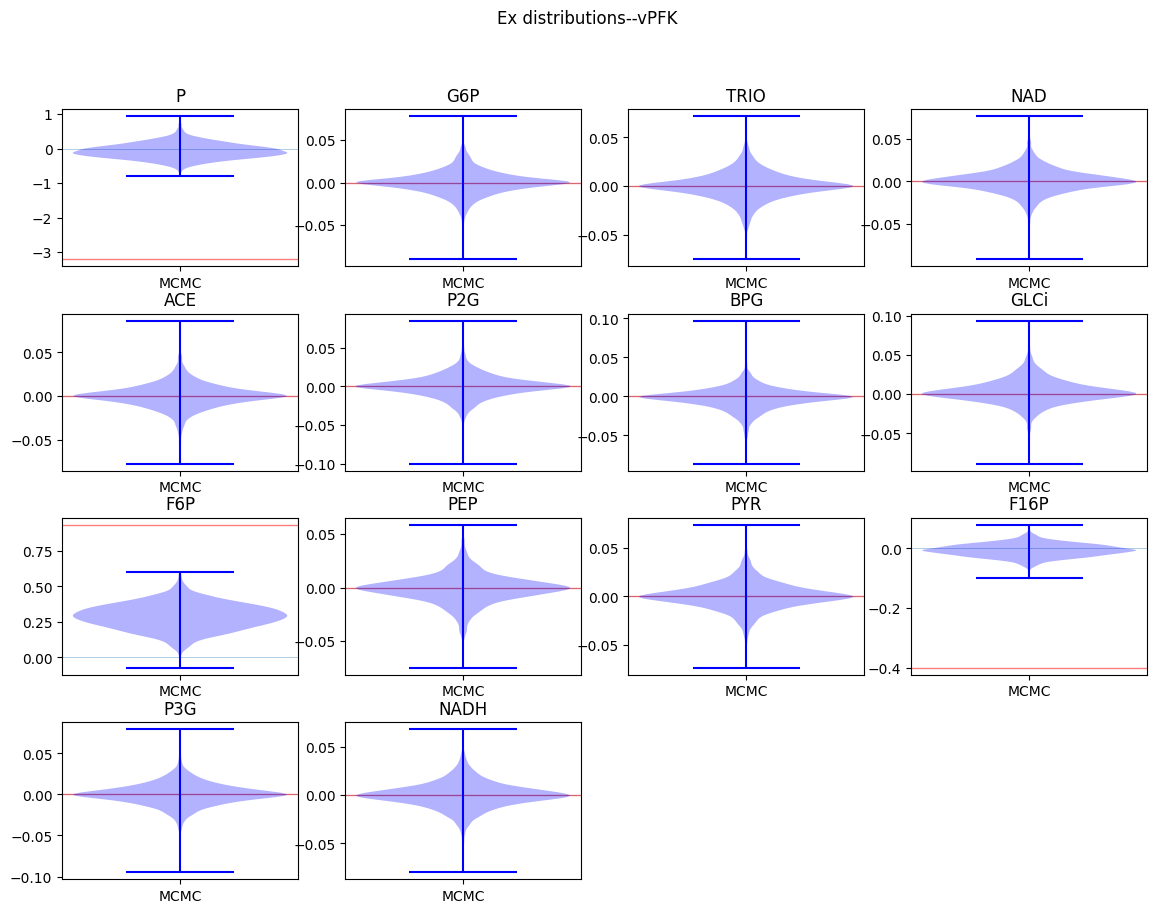

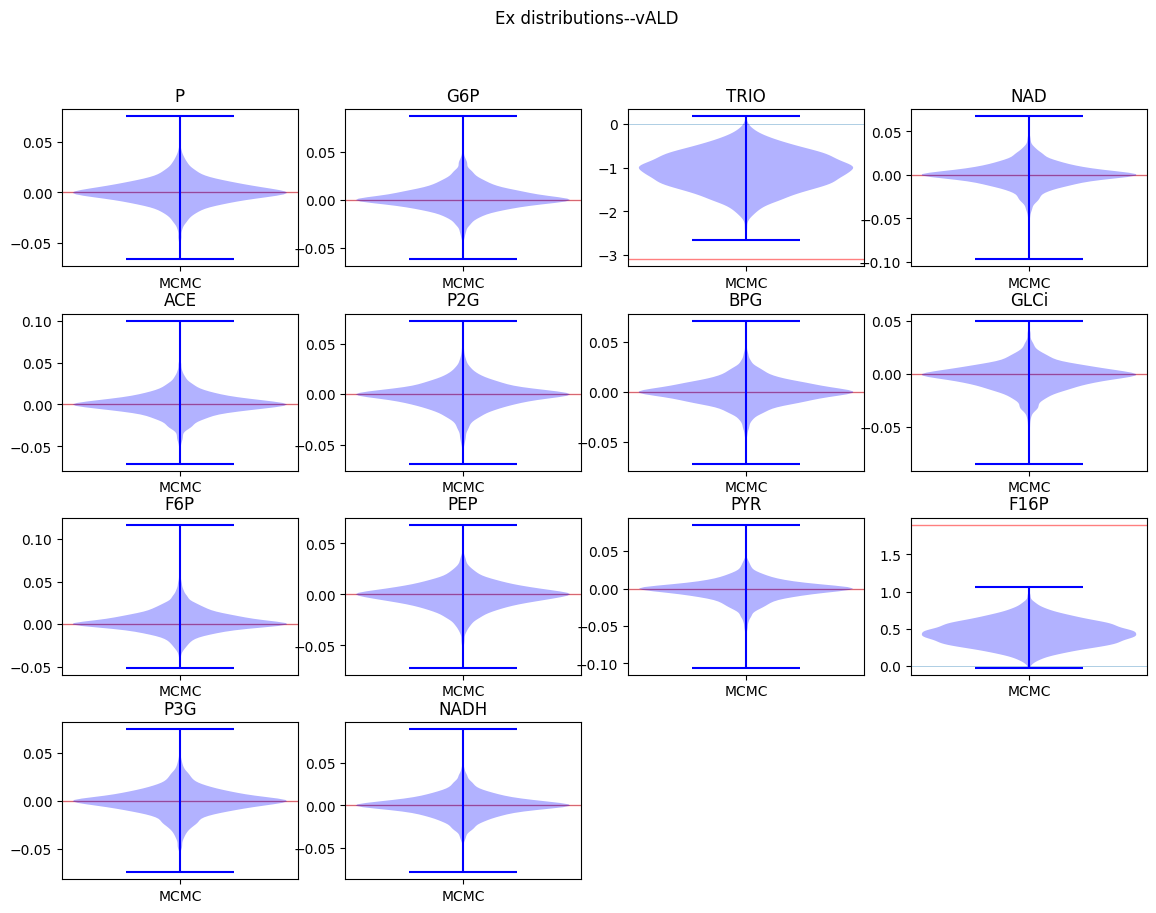

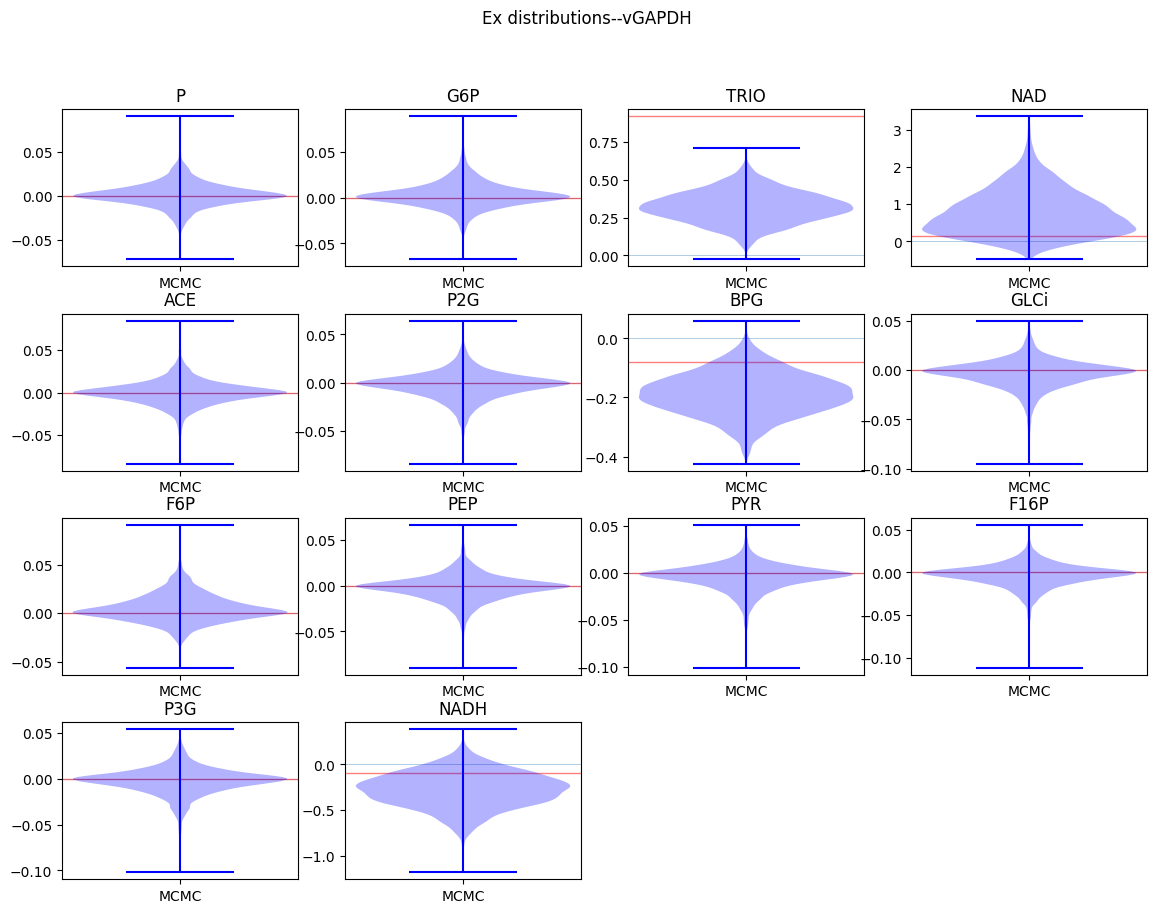

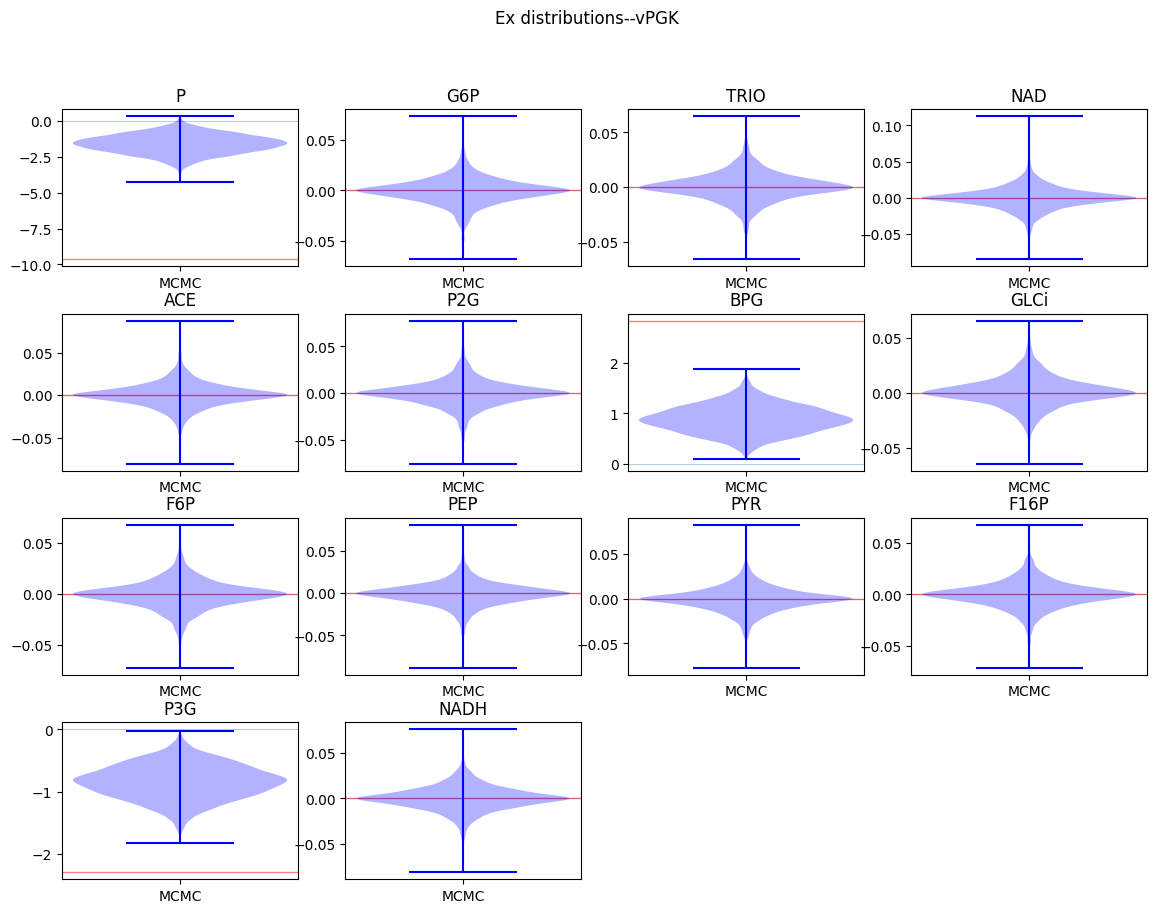

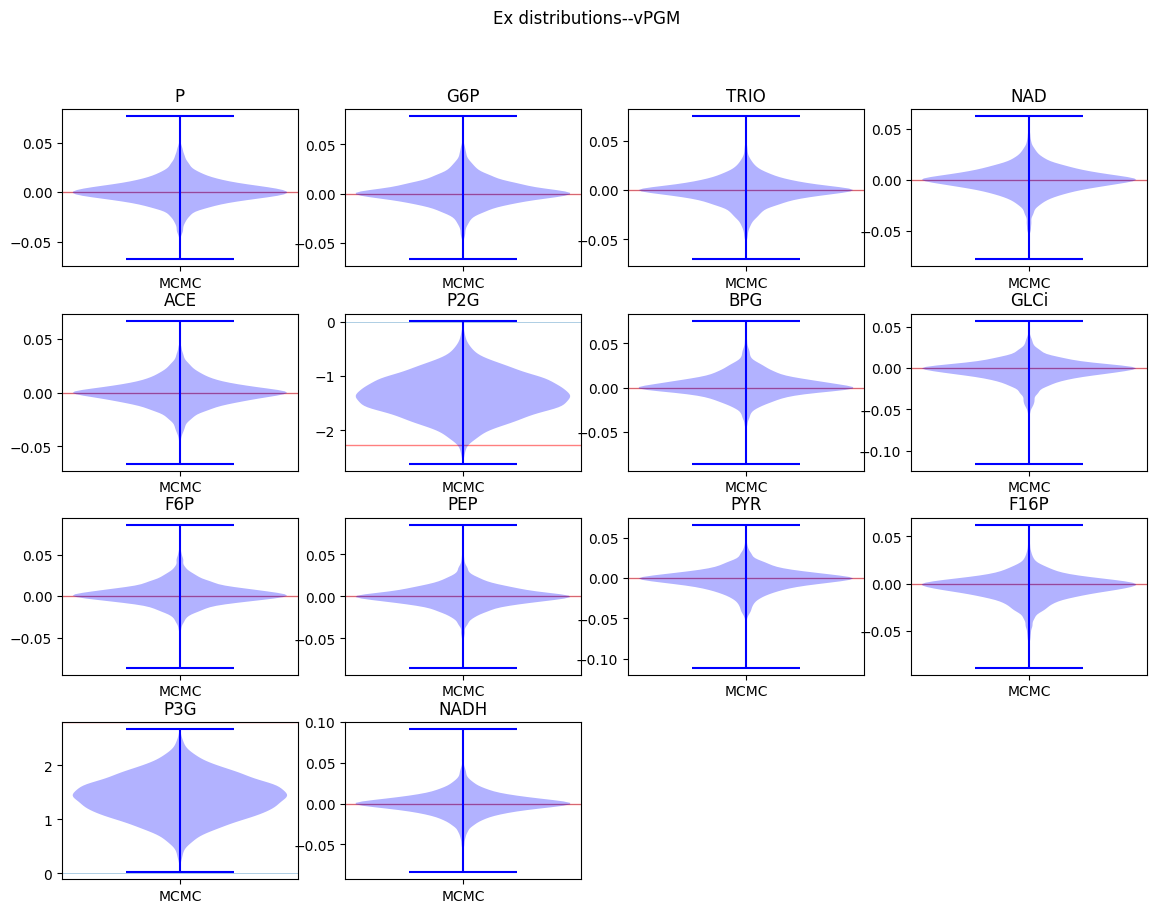

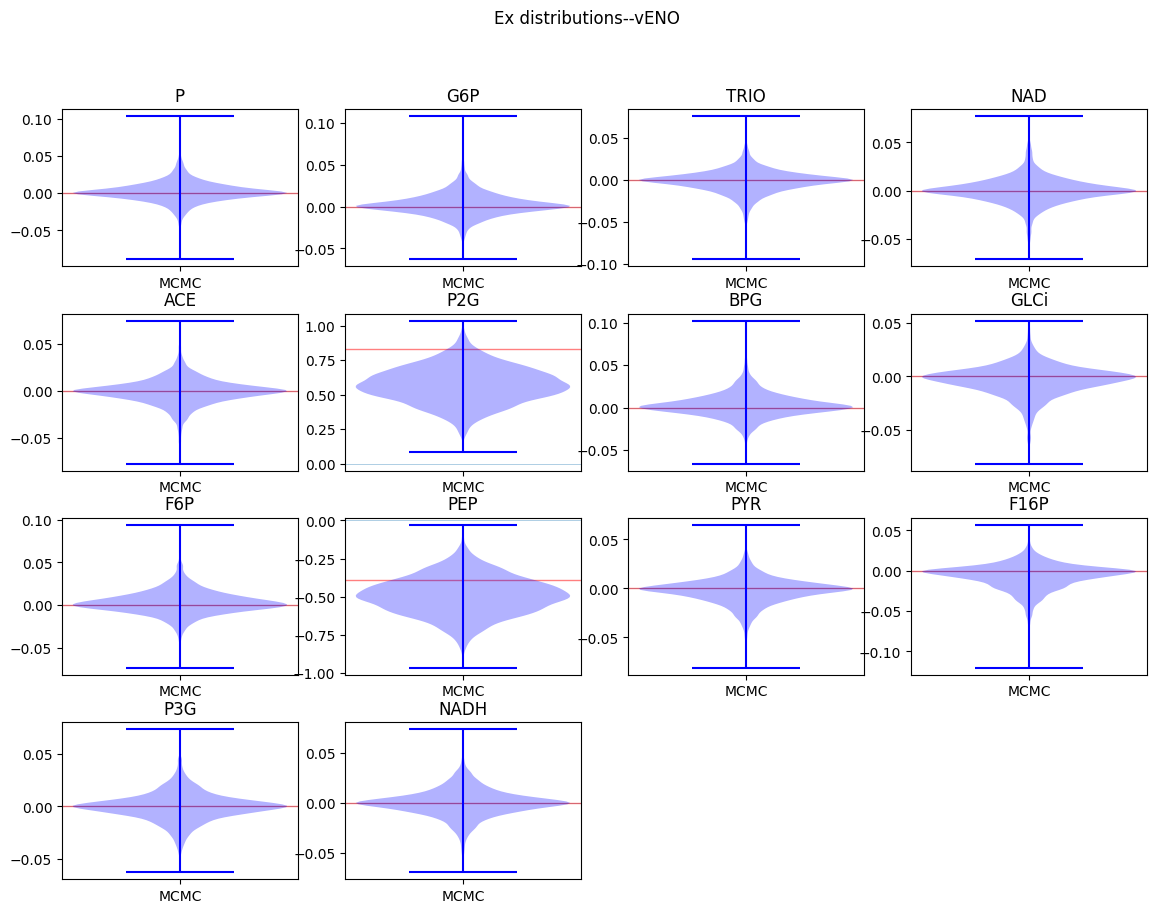

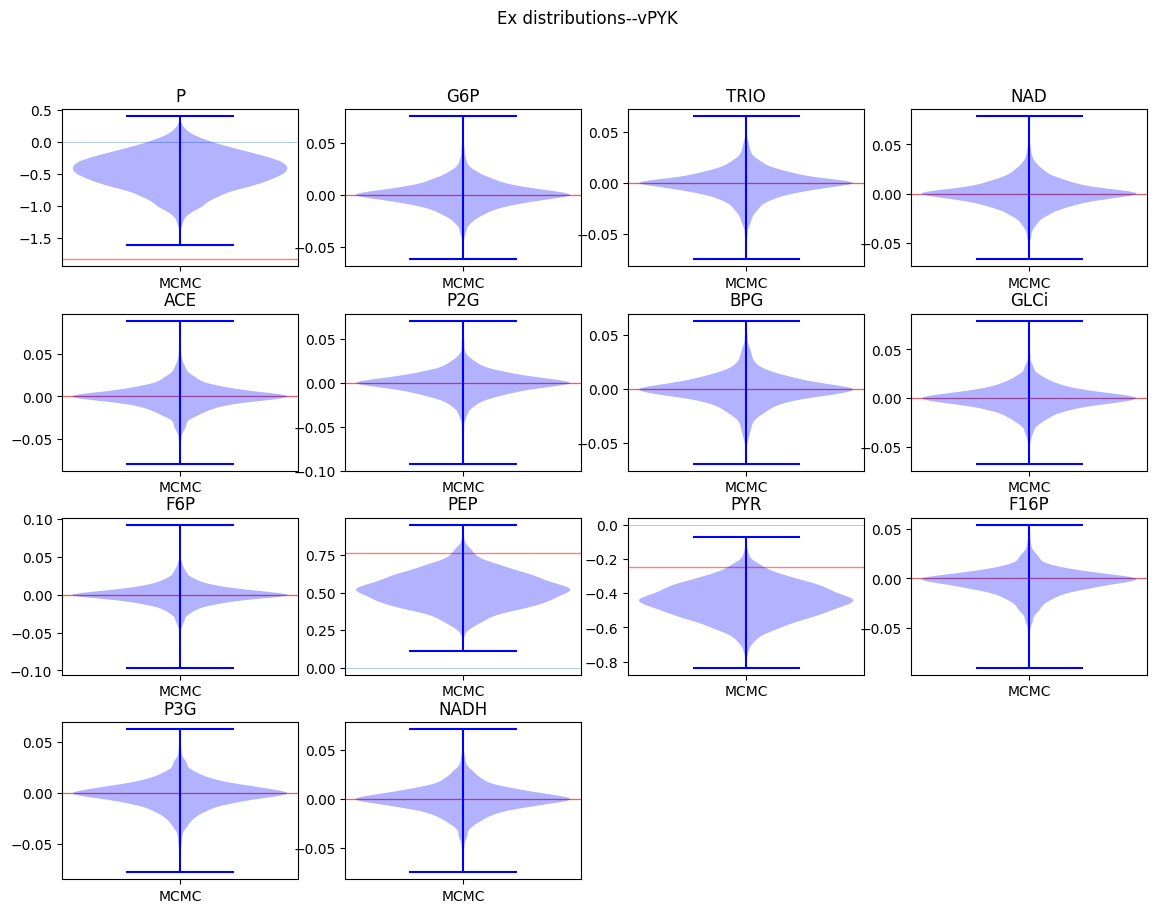

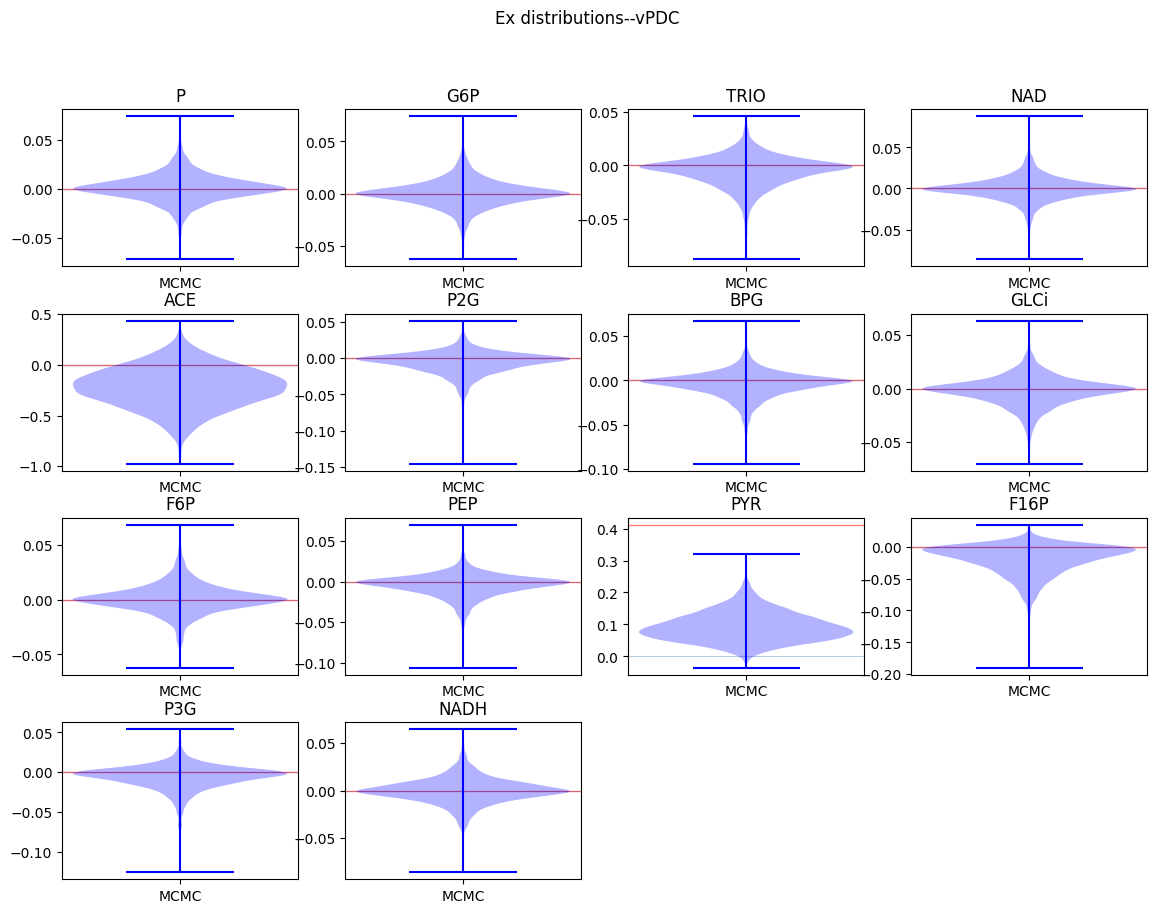

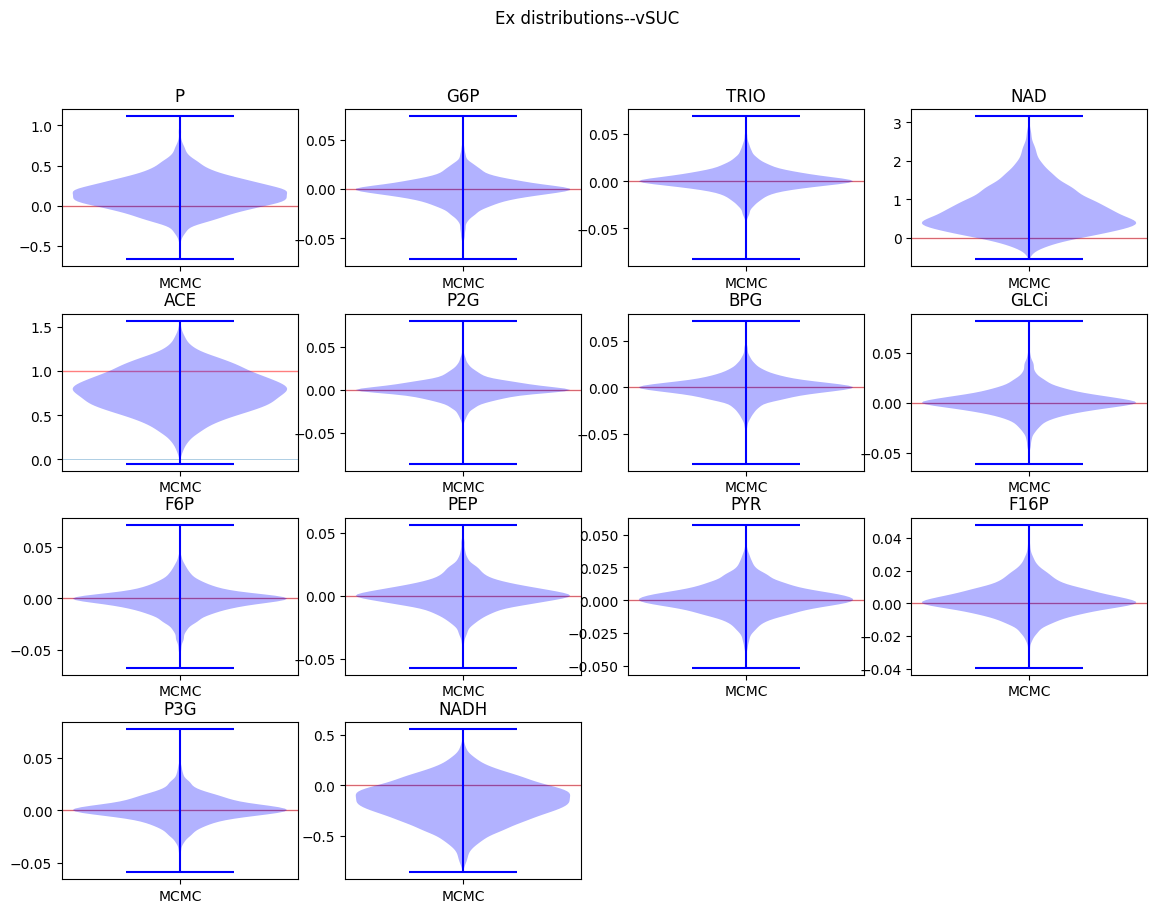

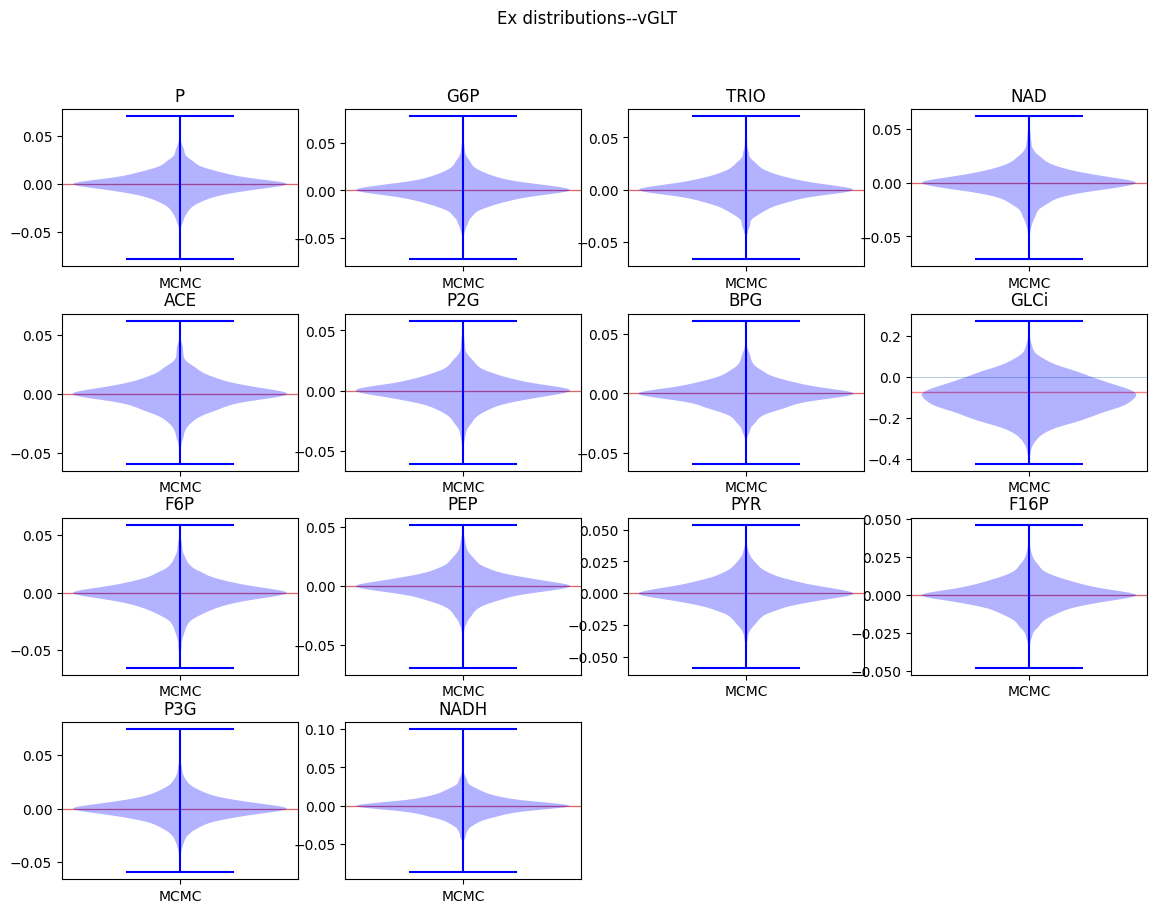

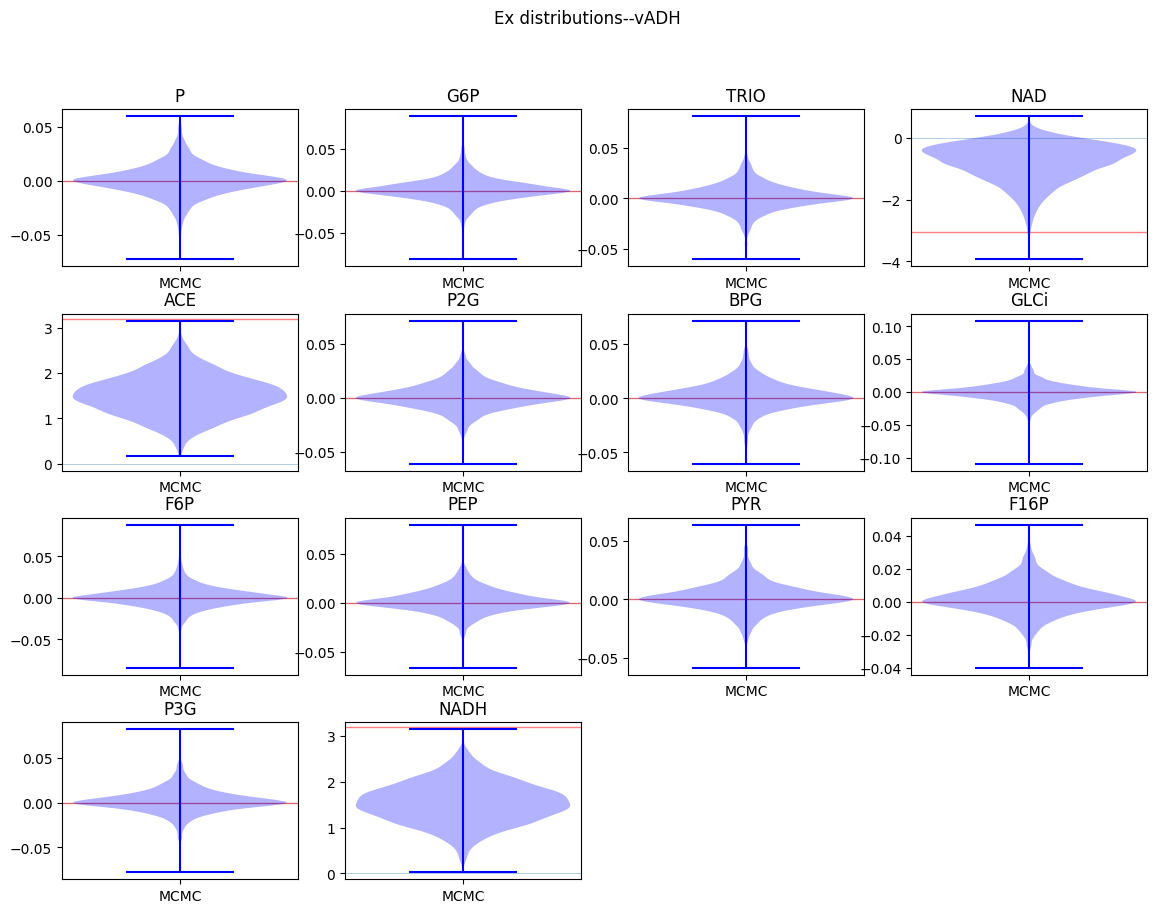

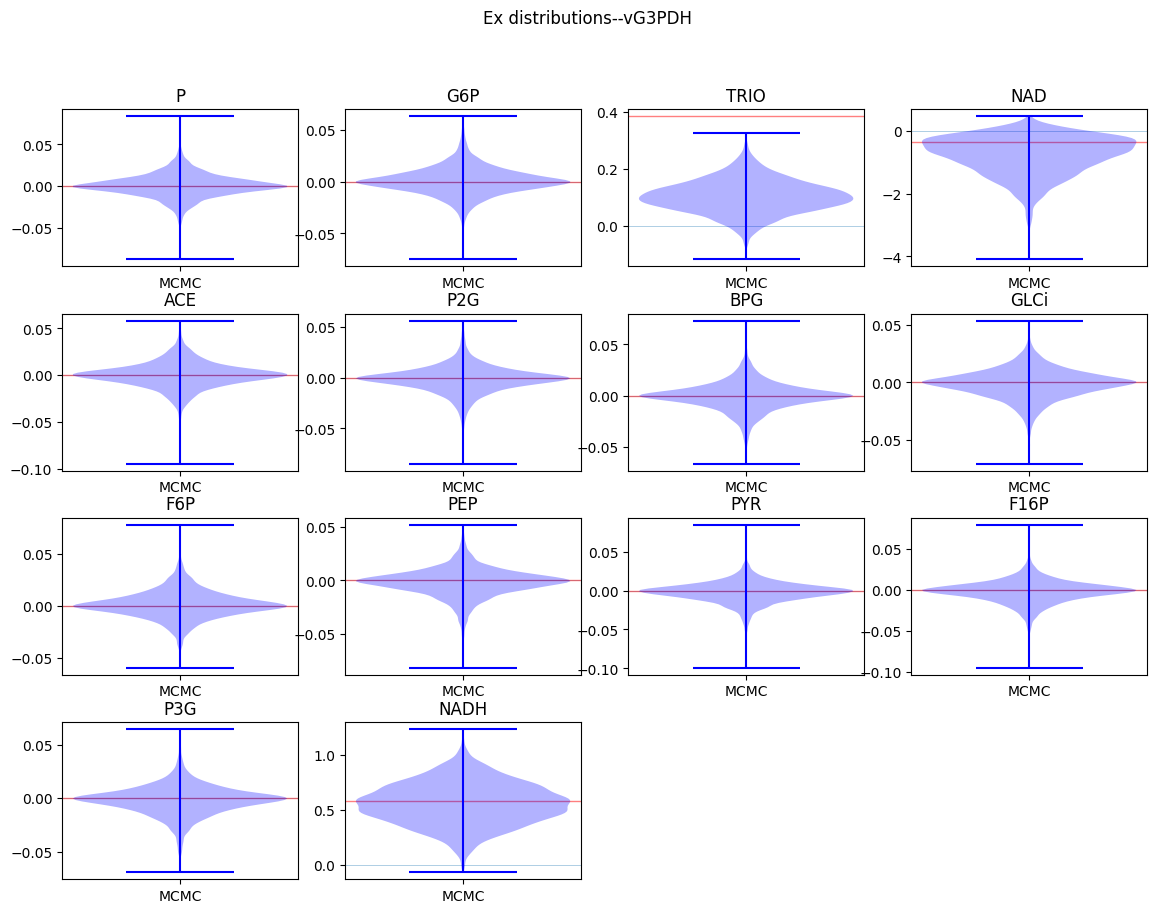

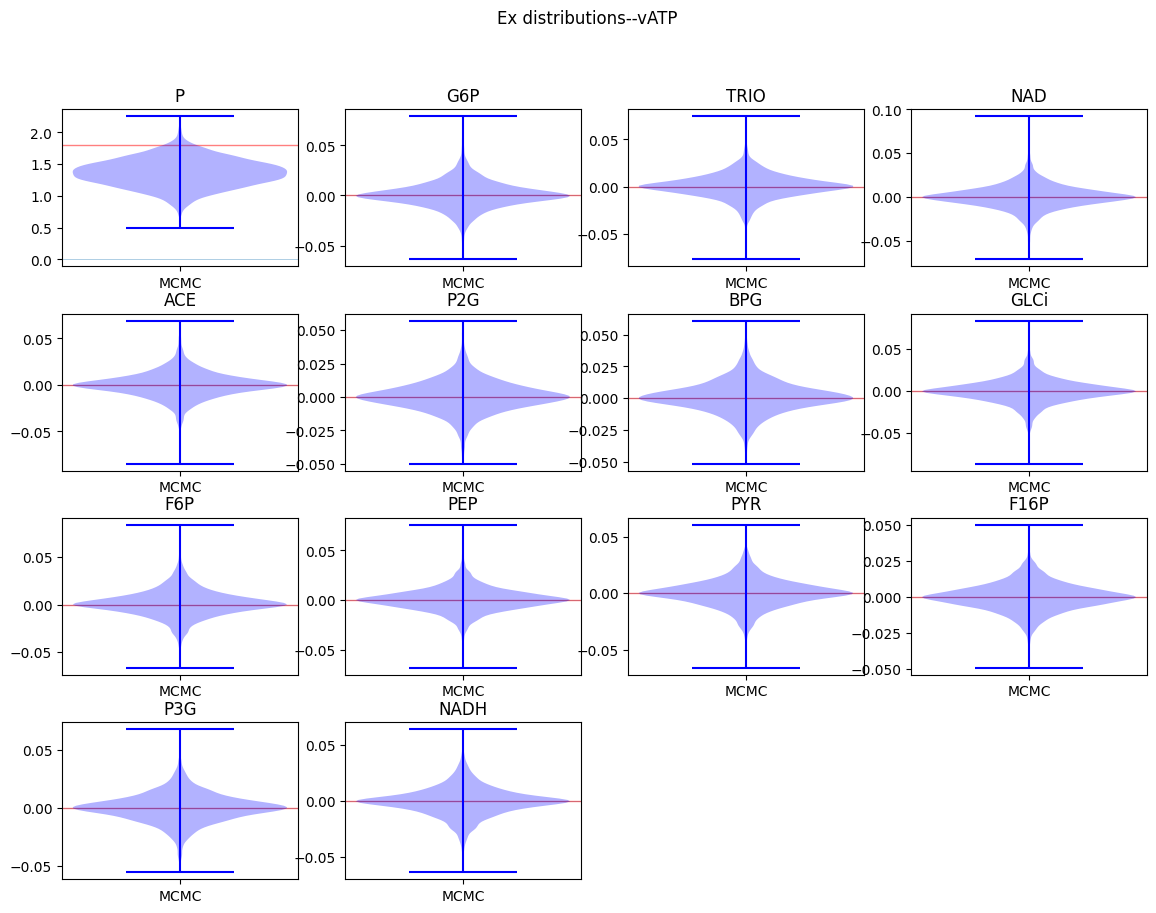

In [8]:
colors = ['blue', 'green', '#fa8602', 'magenta', '#07f53b', '#2312b8']

for i,rxn in enumerate(r.getReactionIds()): #['vADH']
    
    fig, ax = plt.subplots(4,4, figsize = (14,10))
    ii=-1
    
    fig.suptitle(f'Ex distributions--{rxn}\n')
    plt.setp(ax, xticks=range(3), xticklabels=[0,'MCMC', 'ADVI'])
    plt.subplots_adjust(hspace=0.3)
    
    for j,met in enumerate(r.getFloatingSpeciesIds()): # ['TRIO'])
        if j%4==0:
            ii += 1

        met_traces=[]
        for trace in [Ex.transpose(1, 2, 0)]: 
            met_traces.append(trace[i,j,:]) 
            
        met_traces = np.array(met_traces).T

        plots = ax[ii, j%4].violinplot(met_traces)

        # Set the color of the violin patches
        for pc, color in zip(plots['bodies'], colors):
            pc.set_facecolor(color)
        plots['cbars'].set_colors(colors)
        plots['cmaxes'].set_colors(colors)
        plots['cmins'].set_colors(colors)
        
        ax[ii, j%4].axhline(0, linewidth=0.5, zorder=0, alpha=0.5)
        ax[ii, j%4].axhline(r.getScaledElasticityMatrix()[i,j], linewidth=1, zorder=0, alpha=0.5,color='red')
        ax[ii, j%4].set_title(met)
    
    fig.delaxes(ax[3,2]) 
    fig.delaxes(ax[3,3]) 

## Backcalculating to check if there are multiple elasticity solutions

In [ ]:
med_Ex = np.median(Ex, axis=0)
med_Ey = np.median(Ey, axis=0)

In [ ]:
BMCA_obj.vn
# d_df is the flux calculated using the Bayesian inference MCMC POSTERIORS for elasticity
MCMC_vn = BMCA_obj.en.values * (np.ones(BMCA_obj.en.T.shape) + med_Ex@(BMCA_obj.xn.T) + med_Ey@(BMCA_obj.yn.T)).T
MCMC_vn_df = pd.DataFrame(MCMC_vn)
MCMC_vn_df.columns = BMCA_obj.vn.columns #r.getReactionIds()
# MCMC_vn_df

Text(0.04, 0.5, 'relative fluxes predicted with Bayesian inference')

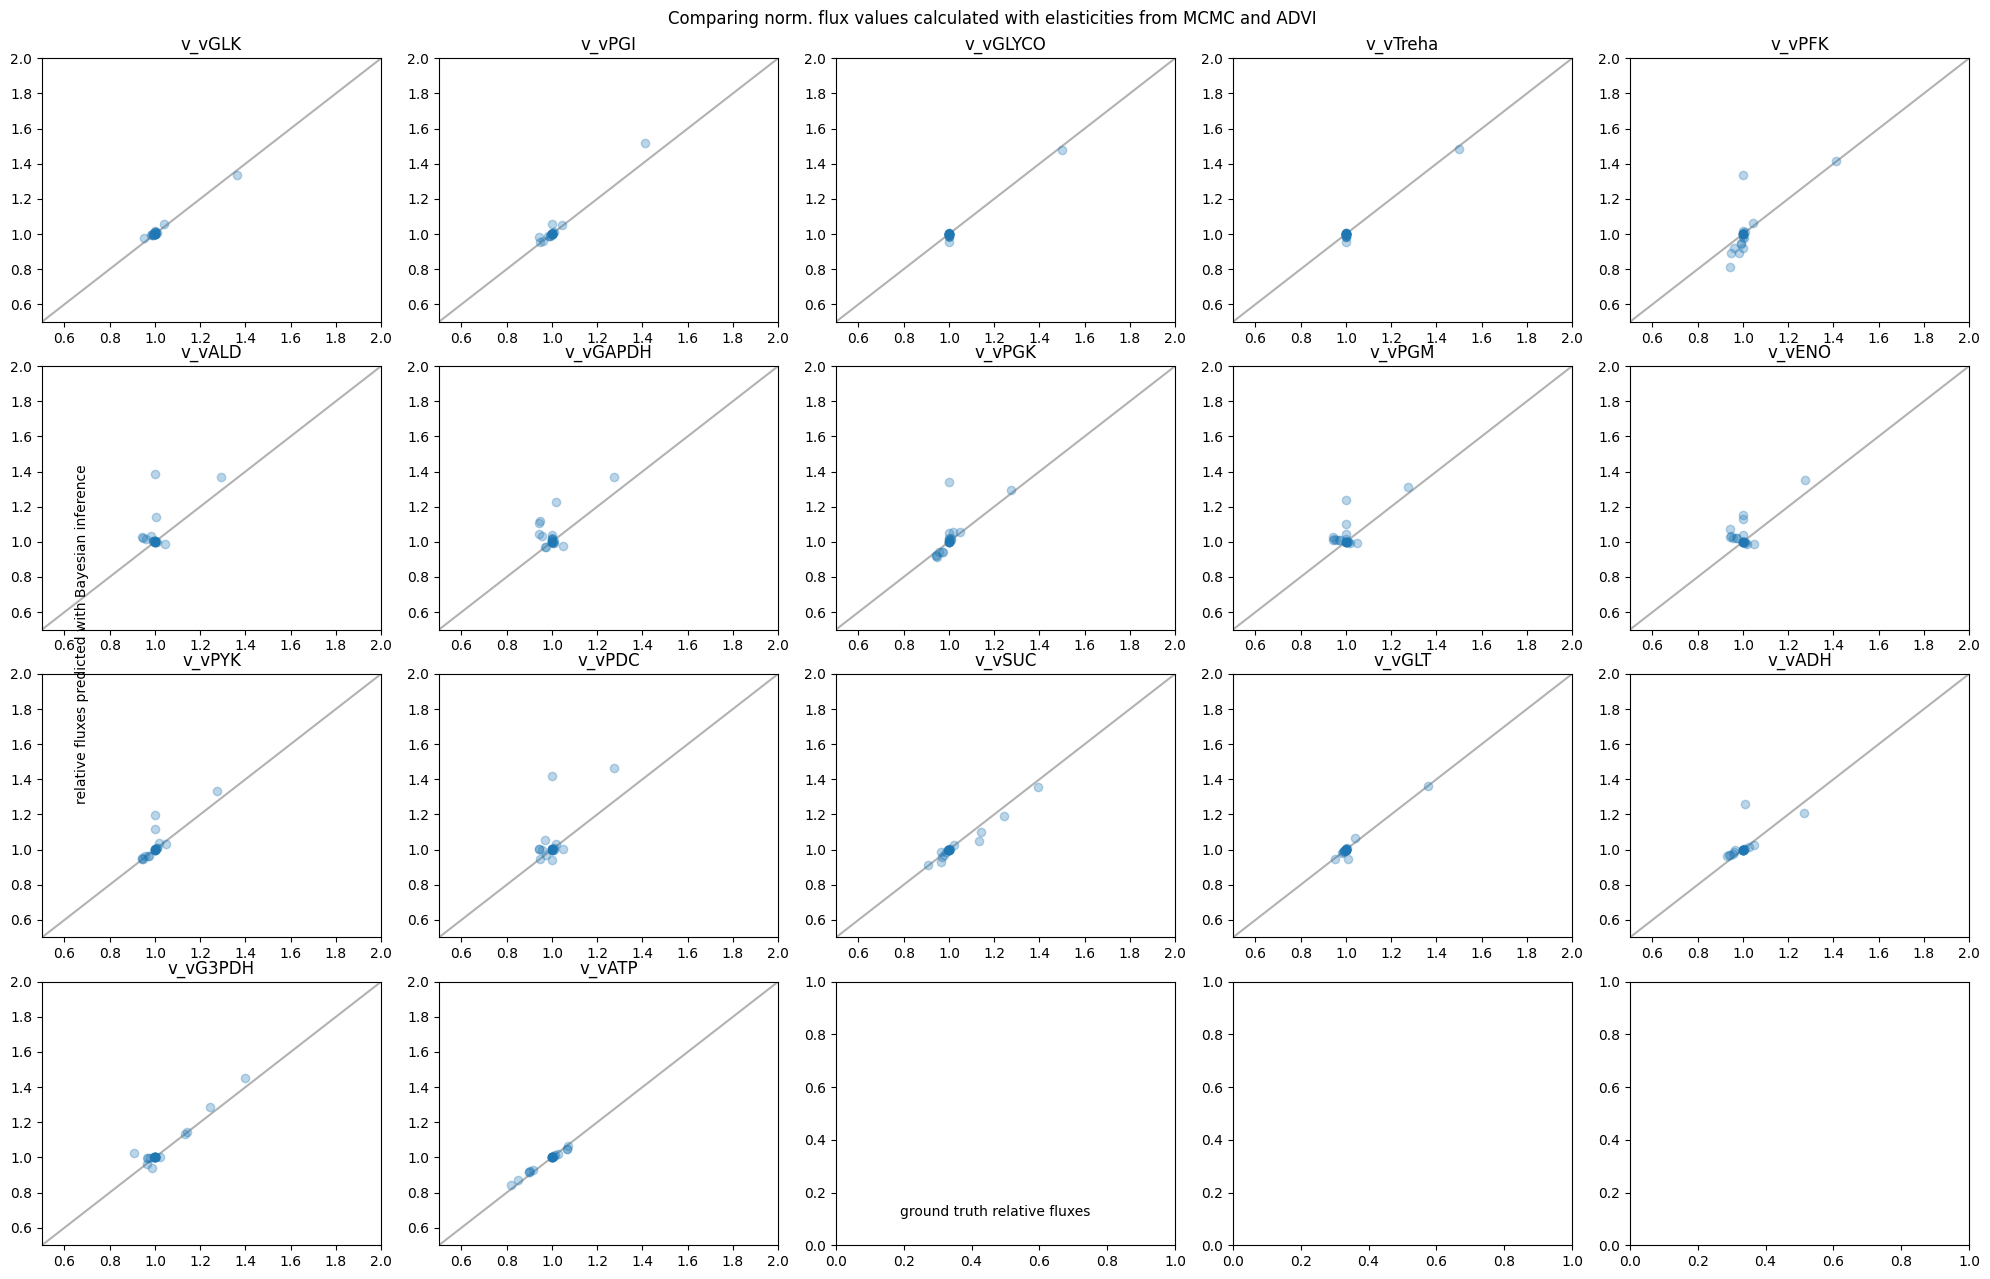

In [13]:
fig, axs = plt.subplots(4,5, figsize=(20, 13)) 
idx_starter = -1

fig.suptitle('Comparing norm. flux values calculated with elasticities from MCMC and ADVI \n')
fig.tight_layout()

lims = [0.5,2]

for i,col in enumerate(MCMC_vn_df.columns): 
    if i%5==0:
      idx_starter += 1
    axs[idx_starter, i%5].plot(lims, lims, 'k-', alpha=0.3, zorder=0)
    axs[idx_starter, i%5].scatter(BMCA_obj.vn[col], MCMC_vn_df[col], alpha=0.3)
    # axs[idx_starter, i%5].scatter(BMCA_obj.vn[col], advi_vn_df[col], alpha=0.3)
    axs[idx_starter, i%5].set_xlim(lims)
    axs[idx_starter, i%5].set_ylim(lims)
    axs[idx_starter, i%5].set_title(col)

fig.text(0.5, 0.04, 'ground truth relative fluxes\n', ha='center')
fig.text(0.04, 0.5, 'relative fluxes predicted with Bayesian inference', va='center', rotation='vertical')


#plt.legend(["fully parameterized", "Visser priors", "real values"])
#plt.show()

### Subtracting the vn values from fluxes calculated using elasticity posteriors

In [14]:
mcmc_dif = MCMC_vn_df-BMCA_obj.vn
# mcmc_dif[mcmc_dif < 1E-1] = 0 
mcmc_dif

,v_vGLK,v_vPGI,v_vGLYCO,v_vTreha,v_vPFK,v_vALD,v_vGAPDH,v_vPGK,v_vPGM,v_vENO,v_vPYK,v_vPDC,v_vSUC,v_vGLT,v_vADH,v_vG3PDH,v_vATP
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.018192,0.007086,0.005520,0.006602,0.020344,-0.057978,-0.068704,0.007451,-0.052734,-0.056573,-0.013855,-0.044837,0.000999,0.029848,-0.024231,-0.021056,-0.016856
2,0.017835,0.053504,-0.000378,-0.002036,0.000306,-0.001215,-0.001641,0.000095,-0.001178,-0.001286,-0.000270,-0.000817,0.000162,0.000159,-0.000537,-0.000421,-0.000292
3,0.011701,0.008671,-0.022879,-0.016623,-0.051913,0.073648,0.102604,-0.019170,0.069902,0.084702,0.010194,0.057919,-0.009189,-0.002528,0.029056,0.028135,0.025049
4,0.008388,0.003403,-0.010115,-0.016694,-0.035973,0.055436,0.075012,-0.015518,0.052285,0.062136,0.007218,0.043530,-0.005667,-0.001857,0.022014,0.021026,0.019553
5,0.012536,0.001113,-0.000006,-0.001202,0.334358,-0.001559,-0.002282,0.000272,-0.001469,-0.001727,-0.000181,-0.000796,0.000458,0.000270,-0.000612,-0.000452,-0.000466
6,0.002384,-0.001842,-0.000007,-0.000213,-0.019744,0.386731,-0.000111,0.000077,0.000146,0.000350,0.000368,0.002249,-0.000170,0.000074,-0.000375,0.000115,-0.000081
7,0.004613,-0.001565,0.005797,0.005520,-0.028563,0.138423,0.206873,0.034833,-0.025302,-0.032851,0.016740,0.013474,0.003828,0.001753,-0.011288,0.115269,-0.017520
8,0.000021,0.000073,0.000205,0.000219,-0.000891,0.003024,0.018242,0.338953,-0.000709,-0.000938,0.000391,0.000613,0.000211,0.000061,-0.000477,0.002631,-0.000454
9,-0.000022,0.000275,0.000191,0.000196,-0.000724,0.002517,0.014687,0.017719,0.235025,-0.000737,0.000416,0.000964,0.000052,0.000074,-0.000482,0.002256,-0.000396
